# Lab 1a: Linear regression

The [NO2 dataset](https://www.openml.org/d/547) contains 500 measurement of pollution caused by cars. The goal is to predict the concentration of $NO_2$ from data about traffic and atmospheric conditions. The predictive variables include the number of cars per hour, temperature, wind, and time of day.

In [1]:
!pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
# Download NO2 data. Takes a while the first time.
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute); 
attribute_names = list(X)

## Quick visualization
We can use pandas to quickly visualize the data. If you are new to pandas, take some time to understand the code.

We'll remove the 'day' feature to focus on the non-temporal aspects of this interaction. We are not aiming to predict future levels, and even if we would it would require special treatment (e.g. different train-test splits). There also doesn't seem to be a long term trend in the data, even though there are clear periodic trends in temperature.

C:\Users\MTS\AppData\Local\Temp\ipykernel_10040\999795560.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));


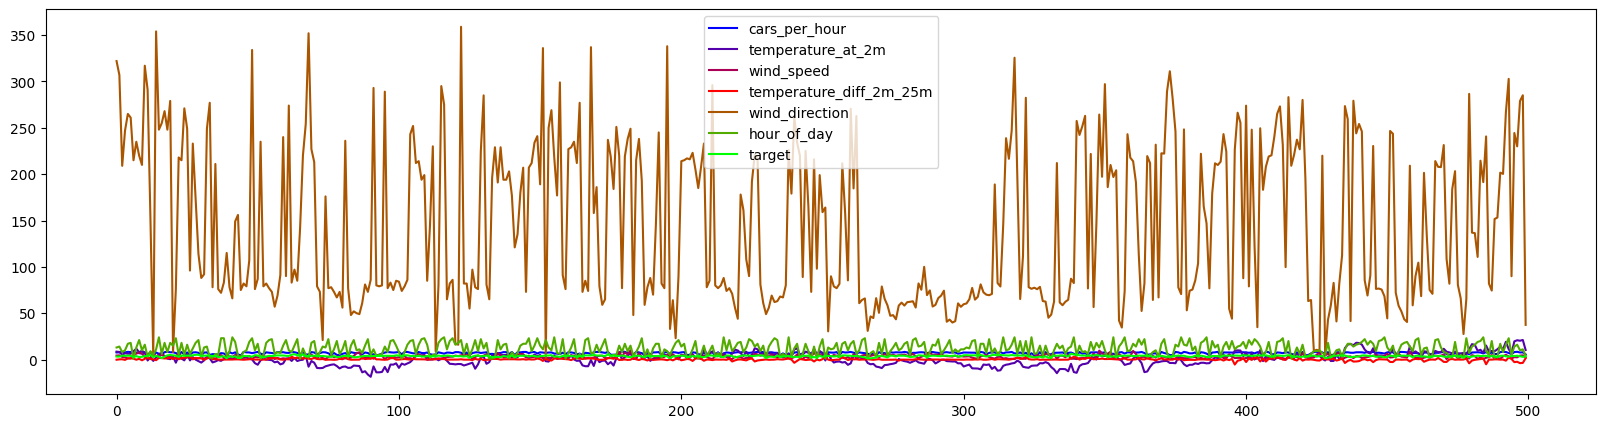

In [98]:
df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(list(y),columns=['target']))
df = df.sort_values(['day','hour_of_day']).drop('day',axis=1)
df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));
X = X.drop('day',axis=1)

In [99]:
df.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,target
42,7.64300,8.5,4.3,-0.2,322.0,13,3.22287
20,7.75061,8.2,4.5,0.2,307.0,14,3.15274
255,8.12415,5.2,2.8,0.3,209.0,8,4.19570
488,7.64108,6.7,2.3,-0.4,247.0,10,3.98155
94,8.31630,6.3,1.2,1.3,265.0,17,4.14155


If we plot the data, ordered by time of measurement, we can see that the wind direction (measured in angular degrees) is scaled very differently from the other features. Let's now zoom in to the other measures:

C:\Users\MTS\AppData\Local\Temp\ipykernel_10040\2419690043.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));


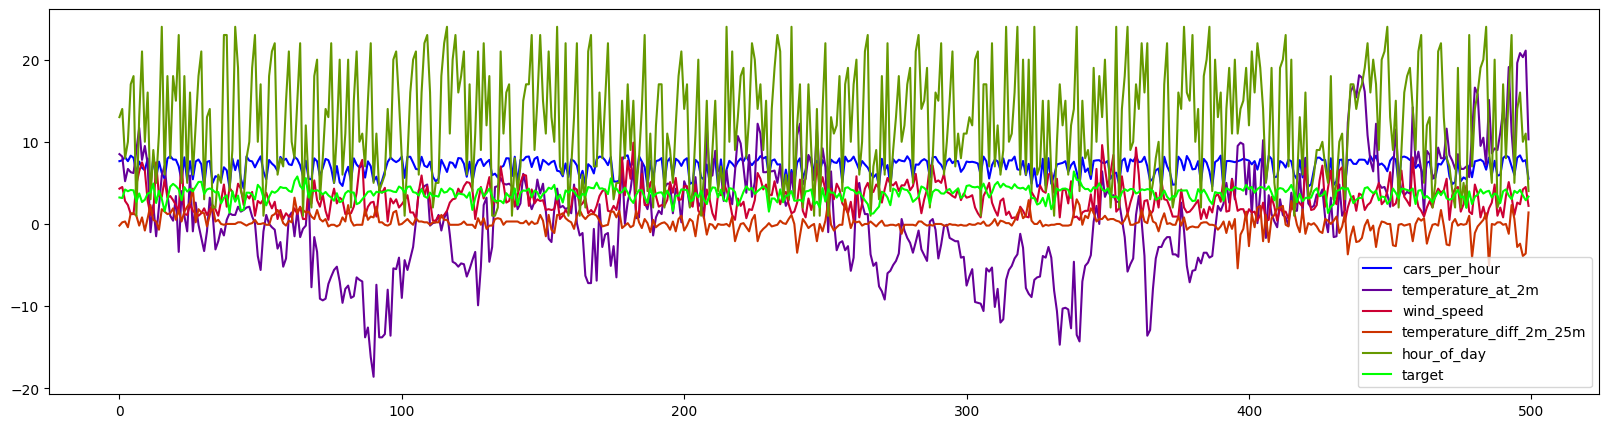

In [100]:
df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));

We can see that the target ($NO_2$ levels) seem to be correlated to the number of cars per hour, which makes sense because cars produce $NO_2$. Other influences (air temperature differences and wind) seem to have a more complex and subtle effect. Let's try to model these using linear regression models.

## Exercise 1: Model benchmark
It is clear that $NO_2$ concentrations depend on a combination of these features, so we will now try to learn this complex relationship. We first evaluate a range of linear regression problems, i.e. Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN. Since we observed that some features have very different scales, we'll also build pipelines of all these measures with an additional scaling step. For now, we'll stick to the default hyperparameter settings. 

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below you the function you will find example output.

In [101]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor


def evaluate_learners(models, X, y):
    """     
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:     
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    train_scores = []
    test_scores = []
    
    for model in models:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),  # Масштабирование признаков
            ("model", model)  # Обучение модели
        ])
        
        scores = cross_validate(pipeline, X, y, cv=5, return_train_score=True)
        
        train_scores.append(scores["train_score"])  # Оценка на тренировочных данных
        test_scores.append(scores["test_score"])  # Оценка на тестовых данных
    
    return train_scores, test_scores

# Создаем список моделей
models = [
    LinearRegression(),
    Ridge(),
    Lasso(alpha=0.01),
    ElasticNet(alpha=0.01),
    KNeighborsRegressor()
]

# Запускаем оценку моделей
train_scores, test_scores = evaluate_learners(models, X, y)

# Вывод результатов
print("Train Scores:", train_scores)
print("Test Scores:", test_scores)


Train Scores: [array([0.51586638, 0.50342001, 0.51871587, 0.50724199, 0.50085031]), array([0.51585674, 0.50340962, 0.51870738, 0.5072327 , 0.50084144]), array([0.5140707 , 0.50149305, 0.51702227, 0.50531495, 0.49899372]), array([0.51515666, 0.5026541 , 0.51805591, 0.50649739, 0.50013513]), array([0.67538819, 0.65162762, 0.658663  , 0.68207956, 0.64387389])]
Test Scores: [array([0.45393592, 0.51229402, 0.41369091, 0.49410071, 0.52646491]), array([0.4544701 , 0.51267813, 0.41392016, 0.49357573, 0.52623096]), array([0.45682115, 0.51963432, 0.41058341, 0.48625081, 0.519625  ]), array([0.45667258, 0.51692748, 0.41292794, 0.48931667, 0.52280428]), array([0.38943485, 0.52405242, 0.39655171, 0.48741658, 0.54669869])]


### Exercise 1.2
Call the function you created with a Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

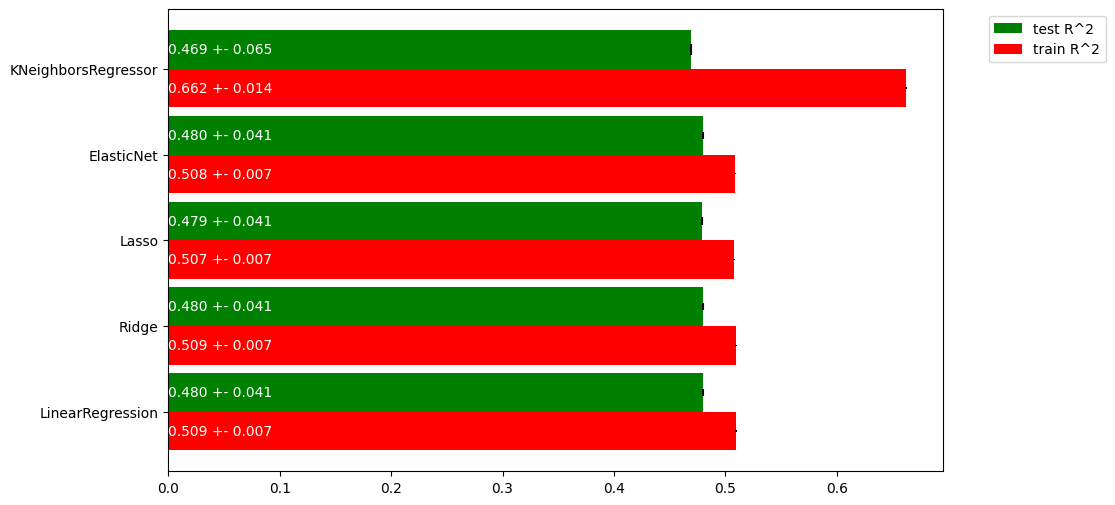

In [104]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots(figsize=(10,6))
width=0.45

ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test R^2')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train R^2')

for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.3f} +- {:.3f}".format(np.mean(te),np.std(te)), color=('white' if np.mean(te)>0.1 else 'black'), va='center')
    ax.text(0, i-width, "{:.3f} +- {:.3f}".format(np.mean(tr),np.std(tr)), color=('white' if np.mean(tr)>0.1 else 'black'), va='center')
labels = [c.__class__.__name__ if not hasattr(c, 'steps') else c.steps[0][0] + "_" + c.steps[1][0] for c in models]

ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. Which is the best regressor? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

Наилучшими моделями являются Linear Regression, Ridge, Lasso и ElasticNet. Они показывают схожие результаты на тестовой выборке с минимальной разницей между обучающей и тестовой ошибками, что указывает на хорошую обобщающую способность.

Переобучение наблюдается у KNeighborsRegressor — заметен большой разрыв между тренировочной и тестовой оценками. Это указывает на то, что модель слишком хорошо подогнана под обучающие данные, но плохо работает на новых.

Решение проблемы:
Для KNeighborsRegressor можно уменьшить количество соседей (n_neighbors), чтобы снизить переобучение.
Проверить другие гиперпараметры, такие как метрика расстояния. В общем, линейные модели стабильно показывают лучшие результаты и требуют меньше подстройки гиперпараметров.

## Exercise 2: Regularization 
We will now tune these algorithm's main regularization hyperparameter: the regularization hyperparameter (`alpha`) in Lasso and Ridge, and the number of neighbors (`n_neighbors`) in kNN.

We expect the optimum for the alpha parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. alpha should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]), n_neighbors should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the hyperparameters in the range given above and, for each regressor, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each regressor. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.

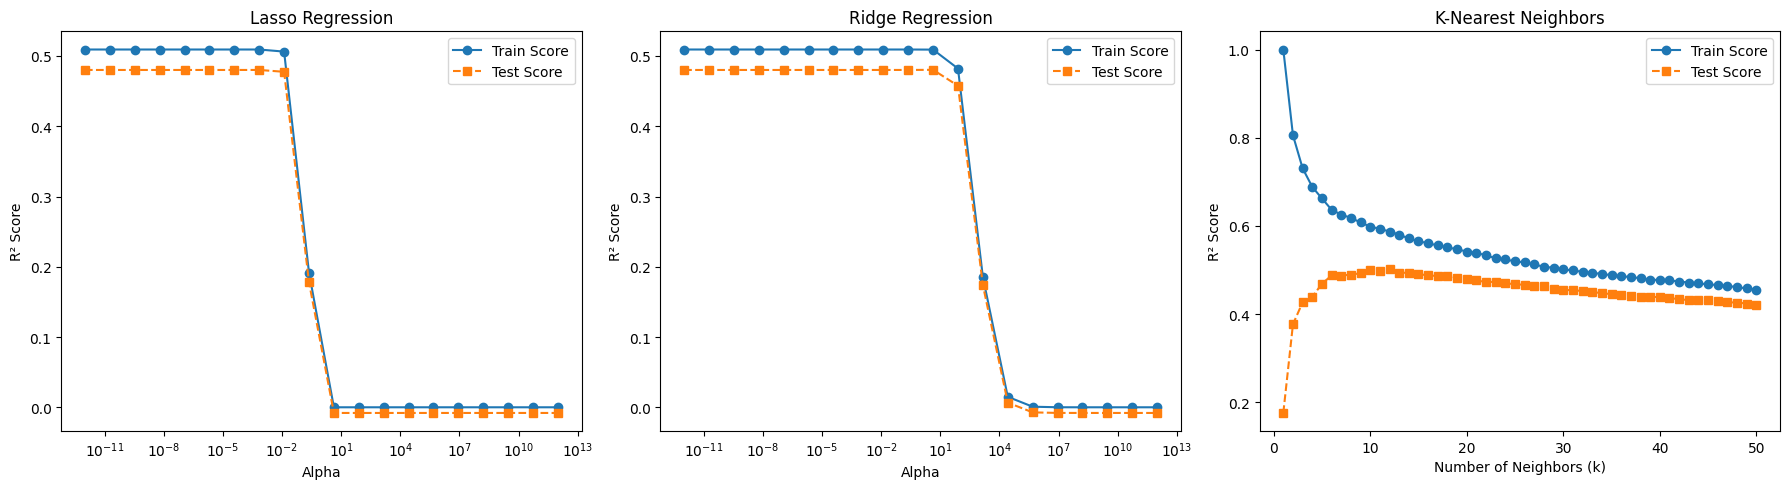

In [105]:
# Определение диапазонов гиперпараметров
alpha_range = np.logspace(-12, 12, num=20)  # Логарифмический диапазон для Lasso и Ridge
n_neighbors_range = np.arange(1, 51)  # Линейный диапазон для KNN

# Функция для оценки моделей на кросс-валидации
def evaluate_model(model, param_name, param_range, X, y):
    train_scores = []
    test_scores = []
    
    for param in param_range:
        # Создаем пайплайн с нормализацией
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model.set_params(**{param_name: param}))
        ])
        
        # Кросс-валидация
        scores = cross_validate(pipeline, X, y, cv=5, return_train_score=True, scoring="r2")
        
        # Запоминаем средние оценки
        train_scores.append(np.mean(scores["train_score"]))
        test_scores.append(np.mean(scores["test_score"]))
    
    return param_range, train_scores, test_scores

# Оценка Lasso
lasso_params, lasso_train, lasso_test = evaluate_model(Lasso(max_iter=5000), "alpha", alpha_range, X, y)
# Оценка Ridge
ridge_params, ridge_train, ridge_test = evaluate_model(Ridge(), "alpha", alpha_range, X, y)
# Оценка KNN
knn_params, knn_train, knn_test = evaluate_model(KNeighborsRegressor(), "n_neighbors", n_neighbors_range, X, y)

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График для Lasso
axes[0].plot(lasso_params, lasso_train, label="Train Score", marker='o', linestyle='-')
axes[0].plot(lasso_params, lasso_test, label="Test Score", marker='s', linestyle='--')
axes[0].set_xscale("log")
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("R² Score")
axes[0].set_title("Lasso Regression")
axes[0].legend()

# График для Ridge
axes[1].plot(ridge_params, ridge_train, label="Train Score", marker='o', linestyle='-')
axes[1].plot(ridge_params, ridge_test, label="Test Score", marker='s', linestyle='--')
axes[1].set_xscale("log")
axes[1].set_xlabel("Alpha")
axes[1].set_ylabel("R² Score")
axes[1].set_title("Ridge Regression")
axes[1].legend()

# График для KNN
axes[2].plot(knn_params, knn_train, label="Train Score", marker='o', linestyle='-')
axes[2].plot(knn_params, knn_test, label="Test Score", marker='s', linestyle='--')
axes[2].set_xlabel("Number of Neighbors (k)")
axes[2].set_ylabel("R² Score")
axes[2].set_title("K-Nearest Neighbors")
axes[2].legend()

plt.tight_layout()
plt.show()


### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

### **Lasso Regression**:
- **Переобучение** при alpha < 10^(-2) – высокий train-score, но test-score ниже.
- **Недообучение** при alpha > 10^2 – оба score резко падают.
- **Чувствительность высокая**: небольшое увеличение alpha после 10^1 резко ухудшает результат.
- **Оптимальный диапазон**: 10^(-2) - 10^1.

### **Ridge Regression**:
- **Переобучение** при alpha < 10^(-2) – train-score выше test-score, но разница небольшая.
- **Недообучение** при alpha > 10^4 – модель слишком простая, score падает.
- **Менее чувствителен** к alpha, чем Lasso, но при очень больших значениях ухудшается.
- **Оптимальный диапазон**: 10^(-2) - 10^1.

### **K-Nearest Neighbors (kNN)**:
- **Переобучение** при k = 1 – train R^2 = 1, test-score сильно ниже.
- **Недообучение** при k > 30-40 – качество падает на обеих выборках.
- **Чувствительность высокая**: малое k → сильное переобучение, большое k → сильное недообучение.
- **Оптимальный диапазон**: k = 10-20.

### Exercise 2.3
ElasticNet allows to mix L1 and L2 loss, and the `l1_ratio` hyperparameter defines the ratio of L1 loss. Hence, it has two interacting hyperparameters: l1_ratio and alpha. Run a grid search to obtain a matrix of l1_ratio and alpha values and the resulting cross-validation scores. Then, use the function provided below to plot a heatmap of all values and interpret the result. Can you explain how the two hyperparameters interact?

c:\Users\MTS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.023e+01, tolerance: 2.811e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


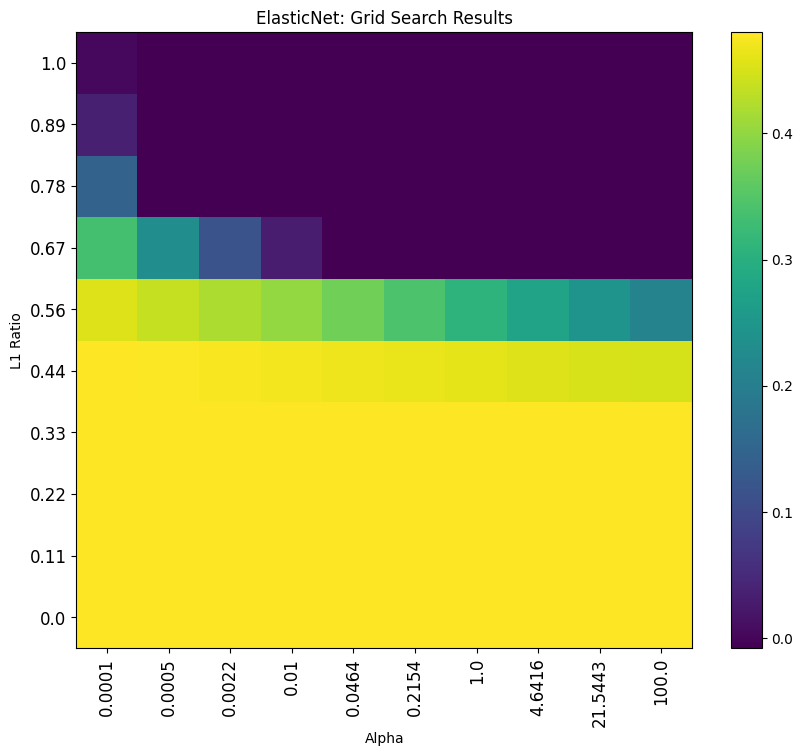

In [106]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.datasets import load_diabetes


# Определение диапазонов гиперпараметров для ElasticNet
alpha_range = np.logspace(-4, 2, num=10)  # От 10^-4 до 10^2
l1_ratio_range = np.linspace(0, 1, num=10)  # От чистого Ridge (0) до чистого Lasso (1)

# Подготовка сетки параметров для GridSearchCV
param_grid = {
    "model__alpha": alpha_range,
    "model__l1_ratio": l1_ratio_range
}

# Создание пайплайна с нормализацией
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=5000))  # Увеличиваем число итераций для сходимости
])

# Запуск GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X, y)

# Формирование матрицы результатов
scores = grid_search.cv_results_["mean_test_score"].reshape(len(l1_ratio_range), len(alpha_range))

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values
    
    values: nxn array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(10, 8))
heatmap(scores, xlabel="Alpha", ylabel="L1 Ratio", 
        xticklabels=np.round(alpha_range, 4), 
        yticklabels=np.round(l1_ratio_range, 2), ax=ax, cmap="viridis")

plt.title("ElasticNet: Grid Search Results", fontsize=12)
plt.colorbar(ax.pcolor(scores, cmap="viridis"))
plt.show()


alpha регулирует степень регуляризации: чем больше, тем проще модель.  

l1_ratio определяет баланс между Lasso и Ridge:
- Lasso (l1_ratio=1) лучше, если нужно выбрать важные признаки.
- Ridge (l1_ratio=0) лучше, если признаки коррелированы.

## Exercise 3: Visualizing coefficients
Finally, let's verify whether the different optimized linear models also find the same coefficients. 

### Exercise 3.1
Draw a [scatterplot](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) plotting the coefficients of the different models in different colors. Do you see much difference between the different models?

For all models, choose an alpha parameter that seems to work well in the previous exercise. When in doubt, use alpha=0.001.

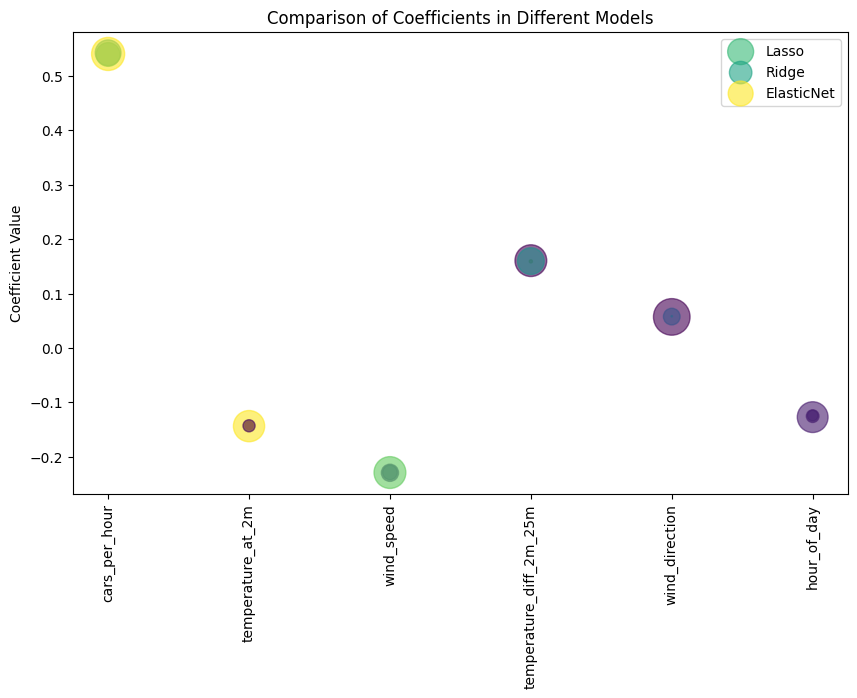

In [118]:
# Определяем feature_names из X (если он уже создан)
feature_names = X.columns.tolist()
# Оптимальный alpha
alpha_opt = 0.001

# Определение моделей с подобранным alpha
models = {
    "Lasso": Lasso(alpha=alpha_opt, max_iter=5000),
    "Ridge": Ridge(alpha=alpha_opt),
    "ElasticNet": ElasticNet(alpha=alpha_opt, l1_ratio=0.5, max_iter=5000)
}

# Хранение коэффициентов
coefficients = {}

# Обучение моделей и сохранение коэффициентов
for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),  # Нормализация данных
        ("model", model)
    ])
    pipeline.fit(X, y)
    coefficients[name] = pipeline.named_steps["model"].coef_

# Конвертация коэффициентов в массив для удобства
coeff_matrix = np.array(list(coefficients.values()))

# Генерация случайных цветов для scatter plot
colors = np.random.rand(len(models), X.shape[1])

# Генерация размеров точек
area = (30 * np.random.rand(len(models), X.shape[1])) ** 2  # 0 to 15 point radii

# Код для построения графика
scatter_data = {
    "coefficients": coeff_matrix,
    "feature_names": feature_names,
    "colors": colors,
    "area": area,
    "model_names": list(models.keys())
}

plt.figure(figsize=(10, 6))

for i, model_name in enumerate(scatter_data["model_names"]):
    plt.scatter(
        x=np.arange(len(scatter_data["feature_names"])),  # Ось X
        y=scatter_data["coefficients"][i],  # Ось Y - коэффициенты модели
        s=scatter_data["area"][i].flatten(),  # Преобразуем в 1D массив
        c=scatter_data["colors"][i].flatten(),  # Цвет точки
        label=model_name,
        alpha=0.6
    )

plt.xticks(range(len(scatter_data["feature_names"])), scatter_data["feature_names"], rotation=90)
plt.ylabel("Coefficient Value")
plt.title("Comparison of Coefficients in Different Models")
plt.legend()
plt.show()



### Exercise 3.2
Redraw the same plot but now using a large amount of regularization (e.g. alpha=1). What do you observe? Does this help you explain the performance difference between Ridge and Lasso in exercise 1.2? 

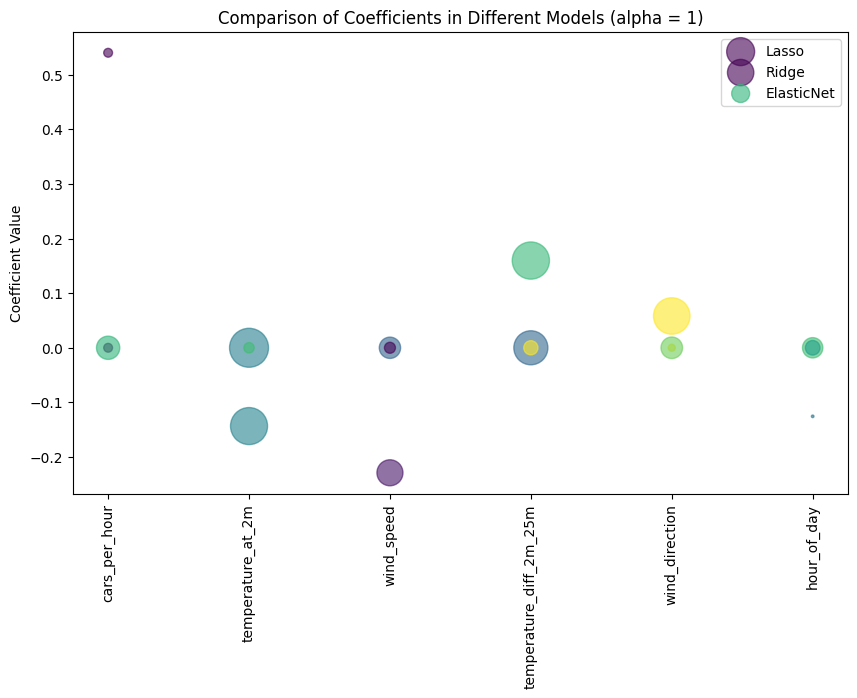

In [128]:
# Определяем feature_names из X (если он уже создан)
feature_names = X.columns.tolist()

# Новый alpha = 1 (увеличенная регуляризация)
alpha_high = 1.0

# Определение моделей с большим alpha
models_high_alpha = {
    "Lasso": Lasso(alpha=alpha_high, max_iter=5000),
    "Ridge": Ridge(alpha=alpha_high),
    "ElasticNet": ElasticNet(alpha=alpha_high, l1_ratio=0.5, max_iter=5000)
}

# Хранение коэффициентов
coefficients_high_alpha = {}

# Обучение моделей и сохранение коэффициентов
for name, model in models_high_alpha.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),  # Нормализация данных
        ("model", model)
    ])
    pipeline.fit(X, y)
    coefficients_high_alpha[name] = pipeline.named_steps["model"].coef_

# Конвертация коэффициентов в массив
coeff_matrix_high_alpha = np.array(list(coefficients_high_alpha.values()))

# Генерация случайных цветов и размеров точек
colors_high_alpha = np.random.rand(len(models_high_alpha), X.shape[1])
area_high_alpha = (30 * np.random.rand(len(models_high_alpha), X.shape[1])) ** 2

# Построение scatter plot
plt.figure(figsize=(10, 6))

for i, model_name in enumerate(models_high_alpha.keys()):
    plt.scatter(
        x=np.arange(len(feature_names)),
        y=coeff_matrix_high_alpha[i],
        s=area_high_alpha[i].flatten(),
        c=colors_high_alpha[i].flatten(),
        label=model_name,
        alpha=0.6
    )

plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.ylabel("Coefficient Value")
plt.title("Comparison of Coefficients in Different Models (alpha = 1)")
plt.legend()
plt.show()


Выводы
Ridge лучше подходит для данных с высокой корреляцией признаков.

Lasso полезен для отбора признаков, но при слишком большом alpha он может "выкинуть" важные переменные.

ElasticNet — хороший баланс, который может работать лучше, чем чистый Ridge или Lasso в сложных задачах.

Таким образом, различия в R^2 в упражнении 1.2 можно объяснить влиянием регуляризации на коэффициенты моделей!